# Remote Sensing II

## Advanced plotting methods

In the last session, we only plotted the satellite data of MSG itself. Unfortunately, we have to follow our instincts (and duty) as Geographers and add some spatial context to the plots so that the viewer knows what exactly she or he sees.

So lets start with the natural color composite of Greece. 

First, we load the data again and resample the scene to our area definition of Greece and its surroundings:

In [1]:
from satpy import Scene
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyresample.geometry import AreaDefinition

In [3]:
dateien = ["../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_20060117120009.nc"]
files = {"seviri_l1b_nc" : dateien}

scn = Scene(filenames=files)
scn.load(["natural_color"])
scn.load(scn.all_dataset_names()[1:])

area_id = "Griechenland"
description = "Griechenland und Umgebung in Mercator-Projektion"
proj_id = "Griechenland"
proj_dict = {"proj": "merc", "lat_ts": 38, 'lon_0': 25}

width = 800    # width of the result domain in pixels
height = 800   # height of the result domain in pixels

llx = -10E5   # projection x coordinate of lower left corner of lower left pixel
lly =  27E5   # projection y coordinate of lower left corner of lower left pixel
urx =  10E5   # projection x coordinate of upper right corner of upper right pixel
ury =  47E5   # projection y coordinate of upper right corner of upper right pixel

area_extent = (llx,lly,urx,ury)
area_def_greece = AreaDefinition(area_id, proj_id, description, proj_dict, width, height, area_extent)

local_scn = scn.resample(area_def_greece)

Now, we can plot the scene and add some coastlines and a lat/lon grid:

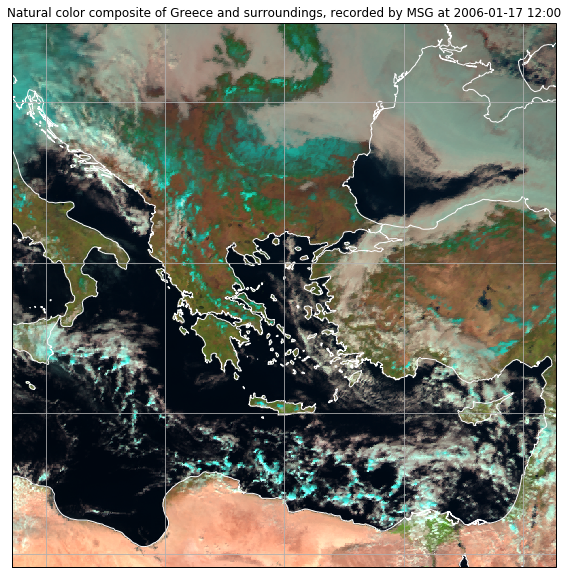

In [6]:
# First, we have to transpose the natural color composite values to a shape that can be interpreted 
# by the imshow method: (M,N,3)
image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)

# Then we scale the values to the range between 0 and 1, clipping the lower and upper percentiles
# so that a potential contrast decrease caused by outliers is eliminated.
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))

# Now we "copy" the coordinate reference system of our composite data set...
crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()

# ... and use it to generate an axes in our figure with the same CRS
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)

# Now we can add some coastlines...
ax.coastlines(resolution="10m", color="white")

# ... and a lat/lon grid:
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

# In the end, we can plot our image data...
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# and add a title to our plot
plt.title("Natural color composite of Greece and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))

# Finally, we can show the plot to the user:
plt.show()

If you want to add further shapes to the plot, you can do so by using the `feature` class of cartopy:

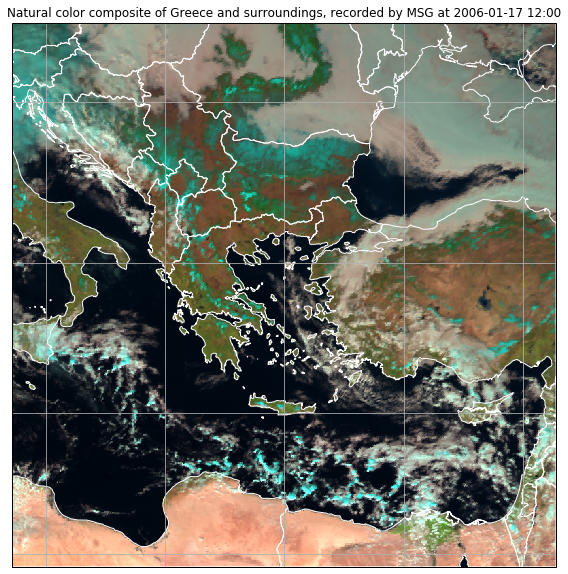

In [7]:
import cartopy.feature as cfeature

image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))
crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

# ===================================================
states_provinces = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_countries",
        scale="10m",
        facecolor="none")
ax.add_feature(states_provinces, edgecolor="white")
# ===================================================

ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.title("Natural color composite of Greece and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))
plt.show()

##### **Task**

1. Download this MSG data set using our usual password: https://box.uni-marburg.de/index.php/s/bCu96BUfVyXtFCg
2. Resample the scene to Algeria and its surroundings using the Mercator projection.
3. Plot the resampled scene as natural color composite, add a grid and country borders as well as a title.

2. ```python
area_def_algeria = AreaDefinition("Algeria", "", "", 
                               {"proj": "merc", "lat_ts": 28, "lon_0": 2}, 
                               1000, 1000, 
                               (-13E5,18E5,12E5,41E5))
local_scn = scn.resample(area_def_algeria)
```

3. ```python
image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))
crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.gridlines(xlocs=range(-15,30,5),ylocs=range(15,47,5))
states_provinces = cfeature.NaturalEarthFeature(
     category="cultural",
     name="admin_0_countries",
     scale="50m",
     facecolor="none")
ax.add_feature(states_provinces, edgecolor="white")
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.title("Natural color composite of Algeria and surroundings, recorded by MSG at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))
plt.show()
```

## Band calculations

As SatPy's Scene class internally uses the xarray data structure to store its data sets, you can do various calculations on these bands with ease.

Often, you will need the difference valus of two bands, which help to highlight certain atmospheric features. For example, the difference values between the bands at 10.8μm and 3.9μm help to distinguish low stratus layers from higher clouds at night.

So, let's first load the MSG scene at 00:00 UTC on 17. January 2006 and resample it to the area of Greece again:

In [15]:
dateien = ["../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_20060117000010.nc"]
files = {"seviri_l1b_nc" : dateien}

scn = Scene(filenames=files)
scn.load(scn.all_dataset_names()[1:])

local_scn = scn.resample(area_def_greece)

No filenames found for reader: seviri_l1b_nc
Don't know how to open the following files: {'../data/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY,MSG1+SEVIRI_C_EUMG_20060117000010.nc'}


ValueError: No supported files found

We can now calculate the difference values by simply subtracting the bands from each other with the `-` operator and we can store them in a new data set within the Scene object:

In [13]:
local_scn["band_diff"] = local_scn["IR_108"]-local_scn["IR_039"]

Let's see what we got:

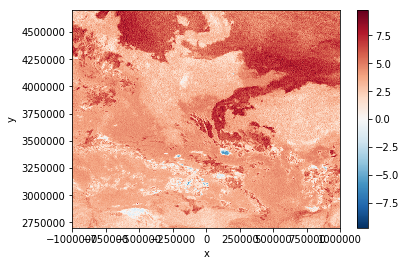

In [15]:
local_scn["band_diff"].plot.imshow()

High difference values indicate low stratus clouds. This means, the dark-red regions in the plot above are covered by low stratus.

By applying a threshold value (~5K), we can generate a low stratus cloud mask for our current scene:

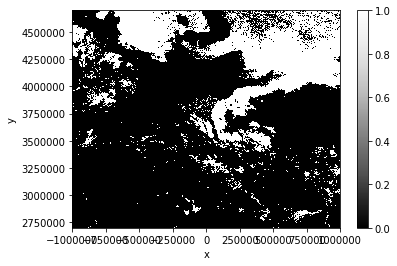

In [30]:
local_scn["stratus_mask"] = local_scn["band_diff"] > 5
local_scn["stratus_mask"].plot.imshow(cmap="Greys_r")

## Loading MODIS data

The MODIS [MOD021KM](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD021KM) data (Level 1B Calibrated Radiances at 1km resolution) can be read and displayed just like the MSG data using SatPy:

In [3]:
#dateien = ["../data/MODIS/MOD021KM.A2006017.1035.061.2017260222353.hdf"]
dateien = ["../data/MODIS/MOD021KM.A2006017.1035.061.2017260222353.hdf"]
files = {"modis_l1b" : dateien}

mod02_scn = Scene(filenames=files)
mod02_scn.load(["1", "natural_color"])
print(mod02_scn.keys())
print(mod02_scn["1"])

[DatasetID(name='1', wavelength=(0.62, 0.645, 0.67), resolution=1000, polarization=None, calibration='reflectance', level=None, modifiers=()), DatasetID(name='natural_color', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)]
<xarray.DataArray (y: 2030, x: 1354)>
dask.array<shape=(2030, 1354), dtype=float32, chunksize=(2030, 1354)>
Dimensions without coordinates: y, x
Attributes:
    name:                 1
    coordinates:          ('longitude', 'latitude')
    platform_name:        EOS-Terra
    modifiers:            ()
    sensor:               modis
    units:                %
    calibration:          reflectance
    file_type:            hdf_eos_data_1000m
    wavelength:           (0.62, 0.645, 0.67)
    level:                None
    standard_name:        toa_bidirectional_reflectance
    resolution:           1000
    polarization:         None
    start_time:           2006-01-17 10:35:00
    end_time:             2006-01-17 10

In [ ]:
scn.show("natural_color")

This gives us an image of the swath data in original MODIS projection. 

But where are we? To find that out, we can resample the data to a simple world map:

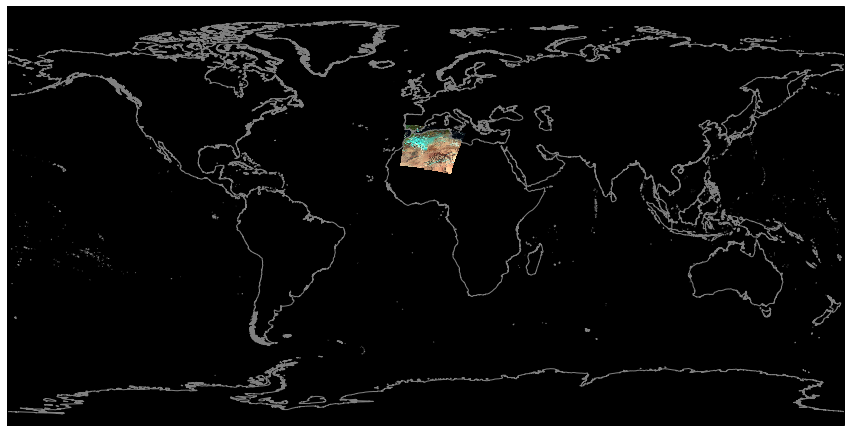

In [25]:
local_scn = scn.resample("worldeqc30km")

image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.nanpercentile(image,1), np.nanpercentile(image,99)), (0, 1))

crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()

fig = plt.subplots(figsize=(15,8))
ax = plt.axes(projection=crs)
ax.coastlines(resolution="10m",color="grey")
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.show()

As MODIS has a very wide aperture angle, the resolution towards the scan margins drops considerably and we can see a lot of distortion at the left and right image borders of the original swath data.

Most often, however, you will want to reproject MODIS data to another projection that is suitable for the covered domain.

This can be done exactly like with the MSG data. So lets resample our MODIS scene to the Algeria domain that we defined above:

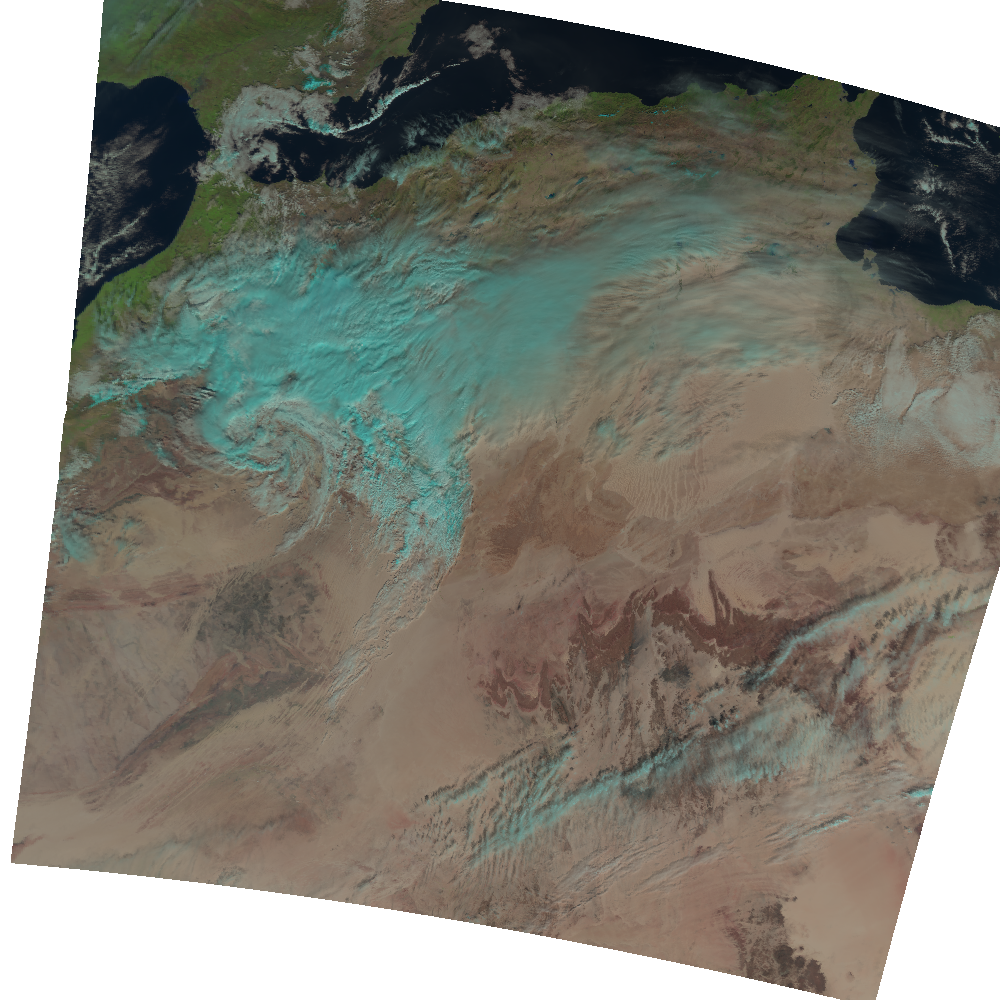

In [42]:
area_def_algeria = AreaDefinition("Algeria", "", "", 
                            {"proj": "merc", "lat_ts": 28, "lon_0": 2}, 
                            1000, 1000, 
                            (-13E5,18E5,12E5,41E5))

local_scn = scn.resample(area_def_algeria)
local_scn.show("natural_color")

And again, with some tweaking, we can also add additional information to the image using CartoPy:

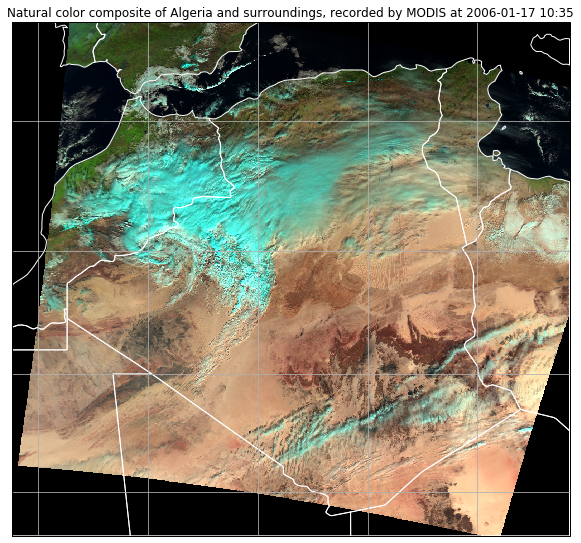

In [46]:
image = np.asarray(local_scn["natural_color"]).transpose(1,2,0)
image = np.interp(image, (np.nanpercentile(image,1), np.nanpercentile(image,99)), (0, 1))
crs = local_scn["natural_color"].attrs["area"].to_cartopy_crs()
fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)
ax.gridlines(xlocs=range(-15,30,5),ylocs=range(15,47,5))
states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    facecolor="none")
ax.add_feature(states_provinces, edgecolor="white")
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")
plt.title("Natural color composite of Algeria and surroundings, recorded by MODIS at " + local_scn.attrs["start_time"].strftime("%Y-%m-%d %H:%M"))
plt.show()

## Loading MODIS L2 data

Currently, [MOD06_L2 data](https://modis-images.gsfc.nasa.gov/MOD06_L2/index.html) cannot be read by SatPy. Fortunately, we can circumvent this problem and use xarray directly. 

So, let's open an example data set:

In [23]:
import xarray as xr
modis_l2 = xr.open_dataset("../data/MODIS/MOD06_L2.A2006017.0855.061.2017271194536.hdf")

That's it. There are many data arrays within this data set that you can list with the `data_vars` attribute. But let's only plot the cloud fraction:

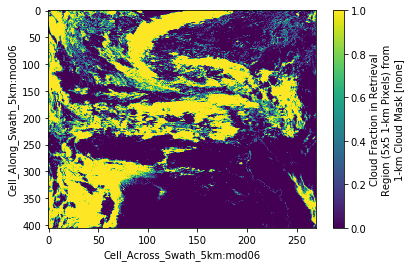

In [6]:
modis_l2["Cloud_Fraction"].plot.imshow(origin="upper")

##### **Task**

1. Download and read the MOD06_L2 data at: https://box.uni-marburg.de/index.php/s/MXrVcvOj9AoFESz
2. Find out the start and end times of the scan.
3. Plot the cloud optical thickness data set

1. ```python
modis_l2 = xr.open_dataset("../path/to/dataset.hdf")
```
2. ```python 
modis_l2.Scan_Start_Time[0,0].values
modis_l2.Scan_Start_Time[-1,-1].values
```
3. ```python
modis_l2["Cloud_Optical_Thickness"].plot.imshow(origin="upper")
```

Ok, looks like it worked. To resample the data, we now have to use the lat/lon bands that come with the MOD06_L2 data set and create a [Swath](https://pyresample.readthedocs.io/en/latest/geo_def.html#swathdefinition) object:

(406, 270)


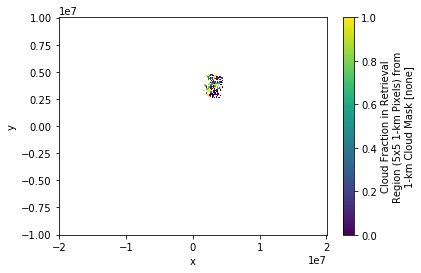

In [27]:
from pyresample import geometry
from satpy import Scene
modis_l2 = xr.open_dataset("../data/MODIS/MOD06_L2.A2006017.0855.061.2017271194536.hdf")
#need to rename dimensions to x,y because satpy expects names to be that way
new_dim_names = {"Cell_Along_Swath_5km:mod06": "y", "Cell_Across_Swath_5km:mod06": "x"}
modis_l2 = modis_l2.rename(new_dim_names)

data = modis_l2["Cloud_Fraction"]
#optionally similar to information found in the mod021km we can assign some more informational attributes
data.attrs["coordinates"] = ("longitude", "latitude")
data.attrs["resolution"] = 5000
print(data.shape)

#create a swath area from lon/lats
lons = modis_l2["Longitude"]
lats = modis_l2["Latitude"]
swath_def = geometry.SwathDefinition(lons,lats)
#and assign the area definition to the area attribute of the data array
data.attrs["area"] = swath_def

#####
#if needed more often the above could be put in a function. maybe do/show that here?
#maybe even put the Scene init and assignment into that function?

def satpy_scn_from_xr(file_or_xr, variables):
    """Creates a satpy Scene from a non supported MODIS product
    
    Will try to create a Satpy Scene with all variables as specified
    in the parameters.
    
    Parameters
    ----------
    file_or_xr : xr.Dataset or str
        Either a filename or an xr.Dataset can be given.
        If filename data will be read using `xr.open_dataset()`.
    variables : list of string
        Names of the variable in the MODIS file which to put in the Scene
    
    Returns
    -------
    satpy.Scene
    
    """
    from pathlib import Path
    from satpy import Scene
    
    if isinstance(file_or_xr, Path):
        modis_l2 = xr.open_dataset(file_or_xr)
    else:
        modis_l2 = file_or_xr
    
    new_dim_names = {"Cell_Along_Swath_5km:mod06": "y", "Cell_Across_Swath_5km:mod06": "x"}
    modis_l2 = modis_l2.rename(new_dim_names)
        
    lons = modis_l2["Longitude"]
    lats = modis_l2["Latitude"]
    swath_def = geometry.SwathDefinition(lons,lats)
    
    #init Scene
    out_scn = Scene()
    #create a Scene dataset for every variable
    for v in varibles:
        ds = modis_l2[v]
        if lons.shape == ds.shape:
            ds.attrs["area"] = swath_def
            out_scn[v] = ds
        else:
            print("The resolution of the lat/lon does not match the shape\
                  of the data of variable {1}. Therefore variable {1} was skipped.".format(v))
    
    return out_scn
    
#####

#init an empty satpy Scene
mod06_scn = Scene()
#assign a new Scene dataset
mod06_scn["cloud_fraction"] = data

#now we can use all satpy functionallity like resampling, 
mod06_scn_res = mod06_scn.resample("worldeqc30km")
#mod06_scn_res.show("cloud_fraction")
mod06_scn_res["cloud_fraction"].plot()

Now we can plot the resampled swath data in the same way, we plotted the MSG data above:

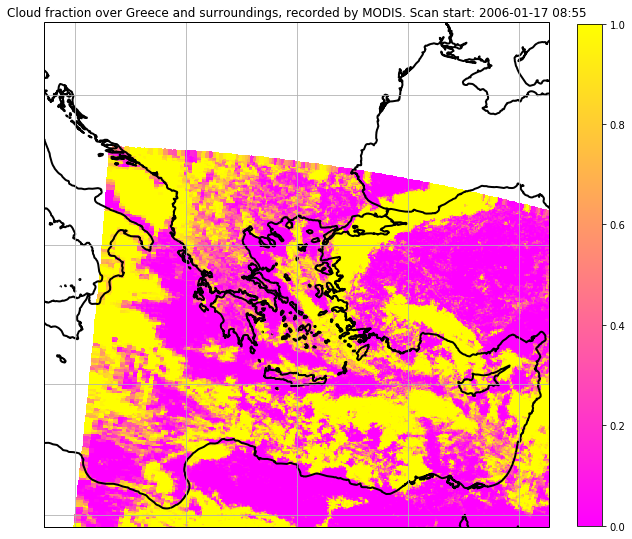

In [43]:
cloud_fraction_resampled = resample_nearest(swath_def, data, area_def_greece, radius_of_influence=20000, fill_value=np.nan)

crs = area_def_greece.to_cartopy_crs()

fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.coastlines(resolution="10m",color="black",lw=2)
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

im = ax.imshow(cloud_fraction_resampled, transform=crs, extent=crs.bounds, origin="upper", cmap="spring")
plt.colorbar(im,fraction=0.045)

ts = pd.to_datetime(str(modis_l2.Scan_Start_Time[0,0].values)) 
d = ts.strftime(""%Y-%m-%d %H:%M")

plt.title("Cloud fraction over Greece and surroundings, recorded by MODIS. Scan start: " + d)
plt.show()

### Concatenate swath data

It is also possible to concatenate multiple swath sections into one large data set. 

So let's load another MODIS swath and concatenate it to the first one:

In [44]:
modis_l2_1 = xr.open_dataset("../data/MODIS/MOD06_L2.A2006017.0850.061.2017271195033.hdf")

In [58]:
data2 = modis_l2_1["Cloud_Fraction"].values
lons2 = modis_l2_1["Longitude"].values
lats2 = modis_l2_1["Latitude"].values

data_combined = np.concatenate([data,data2],axis=0)
lats_combined = np.concatenate([lats,lats2],axis=0)
lons_combined = np.concatenate([lons,lons2],axis=0)

swath_def = geometry.SwathDefinition(lons_combined,lats_combined)

cloud_fraction_resampled = resample_nearest(swath_def, data_combined, area_def_greece, radius_of_influence=20000, fill_value=np.nan)

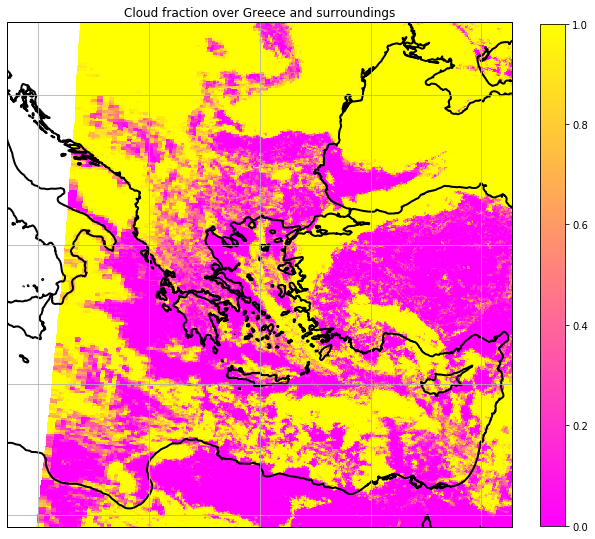

In [60]:
crs = area_def_greece.to_cartopy_crs()

fig = plt.subplots(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.coastlines(resolution="10m",color="black",lw=2)
ax.gridlines(xlocs=range(10,45,5),ylocs=range(25,55,5))

im = ax.imshow(cloud_fraction_resampled, transform=crs, extent=crs.bounds, origin="upper", cmap="spring")
plt.colorbar(im,fraction=0.045)

ts = pd.to_datetime(str(modis_l2.Scan_Start_Time[0,0].values)) 
d = ts.strftime(""%Y-%m-%d %H:%M")

plt.title("Cloud fraction over Greece and surroundings")
plt.show()

## Combining multiple satellite formats

- MSG und MODIS Szenen (in SatPy-Szene) zusammenfügen (in resampled area)
- Berechnungen zwischen beiden Datensätzen machen

- salem einbauen?

# Notes

- links zu "einfachen" informationen zu Wolken tests
    - https://www.intechopen.com/books/advances-in-geoscience-and-remote-sensing/automated-detection-of-clouds-in-satellite-imagery
    - https://www.cfa.harvard.edu/~xliu/res/CloudRetrieval.htm
    - Modis tests ab seite 14: https://modis-atmosphere.gsfc.nasa.gov/sites/default/files/ModAtmo/MOD35_ATBD_Collection6_1.pdf